# Divergence Analysis 

The model that has been used for the divergence analysis

![alt text](modeltarget.png "Title")

### Imports

In [483]:
import pandas as pd
import matplotlib.pyplot as plt
import amplpy

In [484]:
model_file = 'divergenceanalysor.mod'
data_file = 'divergenceanalysor.dat'
run_file = 'divergenceanalysor.run'

ampl = amplpy.AMPL()
ampl.read_data(run_file)
ampl.close()





















*** Start of file divergenceanalysor.run : Wed Apr 05 16:29:38 2023

*** Reading algorithmic controls and parameters in file
PARAM_ALGO_VALUES [*] :=
;

Parameter: threshold to decide wether an active or reactive power value is zero Pnull:=0.01 (MW or Mvar or MVA)
Parameter: threshold to detect zero impedance branch Znull:=0.0001 pu
Parameter: for consistency checks of minimum nominal voltages epsilon_nominal_voltage:= 1 kV
Parameter: for consistency checks of voltage bounds eps<=Vmin<Vmax<=2-eps, epsilon_min_voltage:= 0.5 pu
Parameter: maximum for generating units parameters Pmin Pmax Qmin Qmax = 9000 MW or Mvar
Parameter: defaultPmax = 1000 MW
Parameter: defaultPmin = 0 MW
Parameter: defaultQmaxPmaxRatio = 0.3 Mvar/MW
Parameter: defaultQmin = -300 Mvar
Parameter: defaultQmax = 300 Mvar
Parameter: minimalQPrange = 1 MW or Mvar

*** Connexity computation
# CCcomp solve: start (Wed Apr 05 16:29:38 2023)

Artelys Knitro 13.2.0: ##### This license is only intended for 

In [485]:
# Import data from network
df_branches = pd.read_table('ampl_network_branches.txt', sep=" ", header=1).drop(columns=["#\"variant\""])
df_buses = pd.read_table('ampl_network_buses.txt', sep=" ", header=1).drop(columns=["#\"variant\""])

# Import values from divergence analysis results
df_var_Vtheta = pd.read_csv("values_Vtheta.csv", sep=";")
df_penal_s = pd.read_csv("values_s.csv", sep=";")
df_penal_sigma = pd.read_csv("values_sigma.csv", sep=";")

     branch  bus1  bus2  admittance  dephor  angper  sigma1  sigma2  sigma3  \
0         1     2    80     941.997     0.0   0.084     0.0     0.0     0.0   
1         2     2    79     679.270     0.0   0.084     0.0     0.0     0.0   
2         3     6   510     102.149     0.0   0.213     0.0     0.0     0.0   
3         4     6   510     102.011     0.0   0.212     0.0     0.0     0.0   
4         5     9   163      57.068     0.0   0.196     0.0     0.0     0.0   
..      ...   ...   ...         ...     ...     ...     ...     ...     ...   
912    1041   618   827     313.873     0.0   0.113     0.0     0.0     0.0   
913    1042   619   828    4047.000     0.0   0.067     0.0     0.0     0.0   
914    1043   620   829     273.663     0.0   0.118     0.0     0.0     0.0   
915    1044   623   830      52.929     0.0   0.056     0.0     0.0     0.0   
916    1046   624   832    9996.166     0.0   0.028     0.0    -0.0     0.0   

     sigma4  ...  sigma8  b_sigma1  b_sigma2  b_sig

### Calculation of sets and params for the rest of the analysis

### Get important penalization values

In [486]:
def return_up_outliers_IQR(series, threshold, verbose=False):
    """ Returns the outliers of the series.
    Outliers are detected with interquantile range.
    Quantile used are the threshold-th and (1-threshold)-th ones."""

    quantile_inf = series.quantile(threshold)
    quantile_sup = series.quantile(1-threshold)
    IQR = quantile_sup - quantile_inf
    outliers = series[(series > quantile_sup + 1.5 * IQR)]

    if verbose:
        print("For series", series.name, ": ")
        print("With quantile inf", threshold, ": {:.2f}".format(quantile_inf))
        print("and with quantile sup", (1-threshold), ": {:.2f}".format(quantile_sup))
        print("giving IQR :", IQR)
        print("Number of outliers :", len(outliers))

    return outliers

def return_up_outliers_Zscore(series, threshold, verbose=False):
    """ Returns the outliers of the series.
    Outliers are detected with z score function > threshold."""
    
    outliers = series[ series.add(-series.mean()).multiply(1/(series.std()+0.00000000001)) > threshold ]
    
    if verbose:
        print("For series", series.name, ": ")
        print("With Z score >", threshold, 
              "number of outliers :", len(outliers))

    return outliers

return_up_outliers_IQR(df_penal_sigma['sigma1'].abs(), 0.1, True)
return_up_outliers_Zscore(df_penal_sigma['sigma1'].abs(), 5, True)

For series sigma1 : 
With quantile inf 0.1 : 0.00
and with quantile sup 0.9 : 0.00
giving IQR : 0.0
Number of outliers : 12
For series sigma1 : 
With Z score > 5 number of outliers : 4


513    1.182
565    0.858
631    0.375
747    0.759
Name: sigma1, dtype: float64

##### About V and theta values

<Axes: >

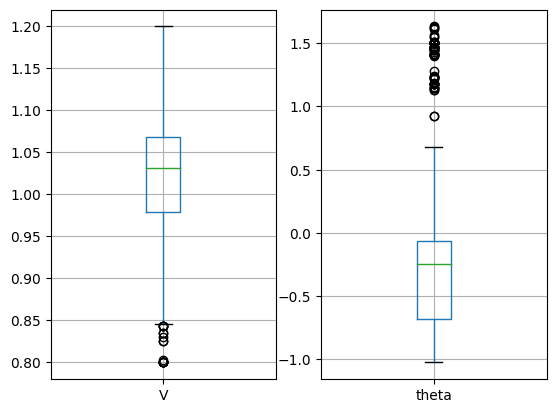

In [487]:
fig, axes = plt.subplots(1,2)
df_var_Vtheta.boxplot(column=['V'], ax=axes.flatten()[0])
df_var_Vtheta.boxplot(column=['theta'], ax=axes.flatten()[1]) 

In [488]:
V_min, V_max, theta_min, theta_max = 0.8, 1.2, -3.141592, 3.141592
count_V_min, count_V_max, count_theta_min, count_theta_max = 0, 0, 0, 0
for index, row in df_var_Vtheta.iterrows():
    if row['V'] <= V_min:
        count_V_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of voltage reached.")
    elif row['V'] >= V_max:
        count_V_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of voltage reached.")
    if row['theta'] <= theta_min:
        count_theta_min += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", min value of theta reached.")
    elif row['theta'] >= theta_max:
        count_theta_max += 1
        print("Bus n°" + str(row['bus']) + ", with id " + row['id'] + ", max value of theta reached.")

print("Total number of buses with min voltage value :", count_V_min)
print("Total number of buses with max voltage value :", count_V_max)
print("Total number of buses with min theta value :", count_theta_min)
print("Total number of buses with max theta value :", count_theta_max)

Bus n°10, with id '1130d141-226d-41d0-9b37-65ca914de3cc_0', max value of voltage reached.
Bus n°83, with id '454214ff-39f8-4999-8489-d2ee3e4c62ab_0', min value of voltage reached.
Bus n°84, with id '454214ff-39f8-4999-8489-d2ee3e4c62ab_1', min value of voltage reached.
Bus n°94, with id 'a2c051ec-41f4-445b-ab3f-705f6e03189f_0', max value of voltage reached.
Bus n°173, with id '91bb860e-ccd3-4f39-8ab1-9b15e836717c_0', max value of voltage reached.
Bus n°174, with id 'dbc83607-fa8c-48b2-b95e-1d3adcfffacb_0', min value of voltage reached.
Bus n°175, with id 'dbc83607-fa8c-48b2-b95e-1d3adcfffacb_1', min value of voltage reached.
Bus n°240, with id '1531cef1-907f-4936-89f5-b67127fd770d_0', max value of voltage reached.
Bus n°248, with id '133c92b2-e9c7-44ea-a188-f6ef577dafdf_0', max value of voltage reached.
Bus n°261, with id '95d08e3a-c4ce-42bf-a956-ede88772eff5_0', max value of voltage reached.
Bus n°429, with id '65dde69d-2a25-424d-a11e-7ef02f9e1736_0', max value of voltage reached.
Bus

##### About s penalization

<Axes: >

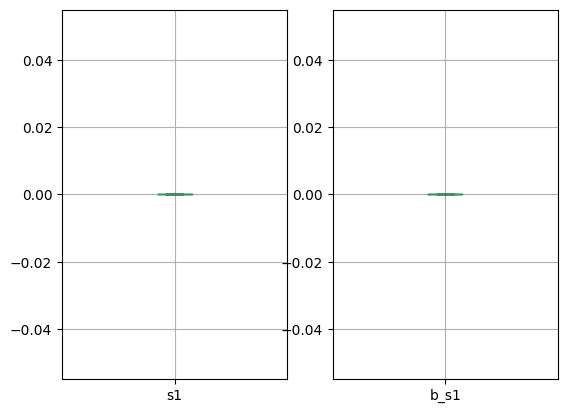

In [489]:
fig, axes = plt.subplots(1,2)
df_penal_s.drop('id',axis=1).abs().boxplot(column=['s1'], ax=axes.flatten()[0])
df_penal_s.drop('id',axis=1).abs().boxplot(column=['b_s1'], ax=axes.flatten()[1])

About sigma penalization

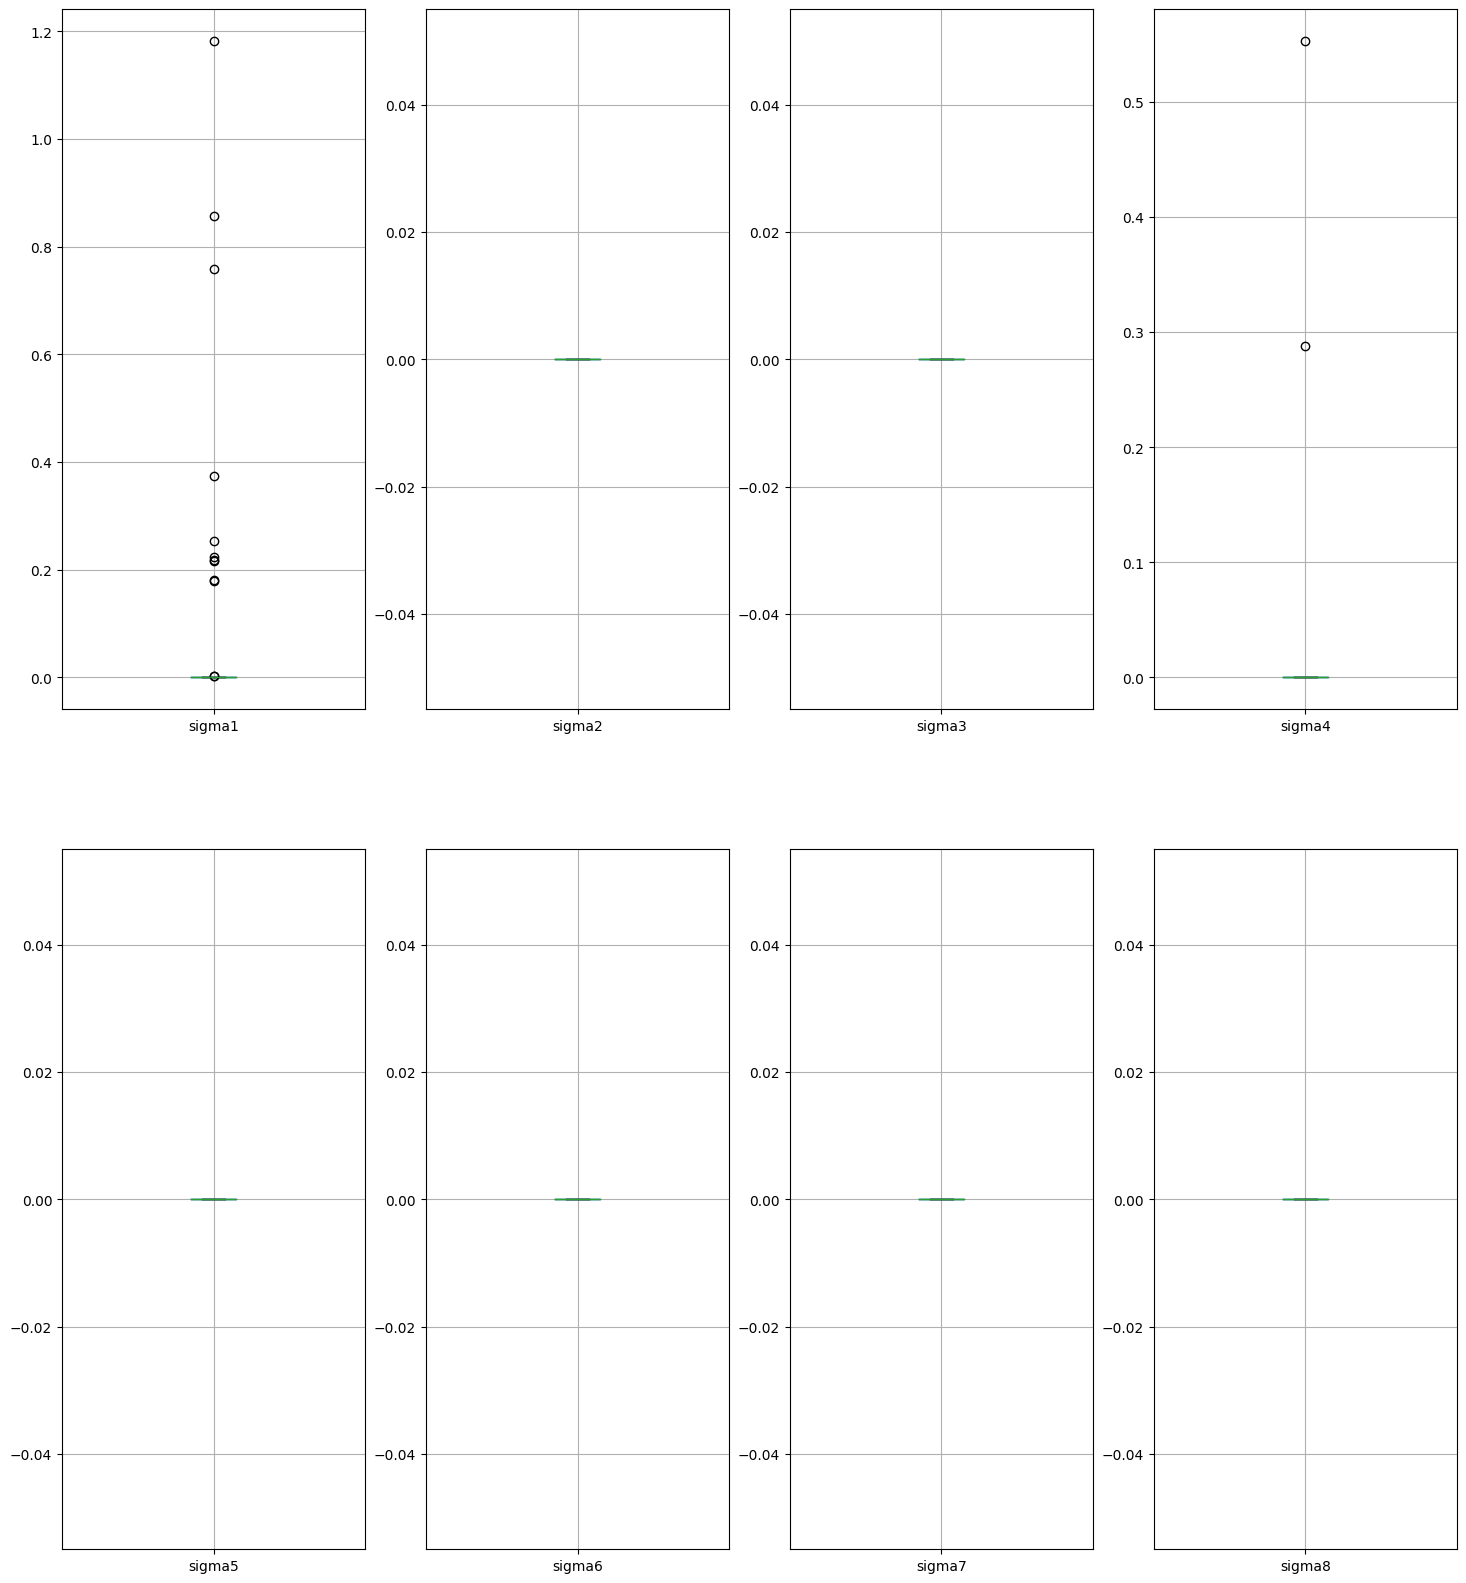

In [490]:
fig, axes = plt.subplots(2,4, figsize=(18,20))
for i in range(1,9):
    df_penal_sigma.boxplot(column=['sigma'+str(i)], ax=axes.flatten()[i-1])

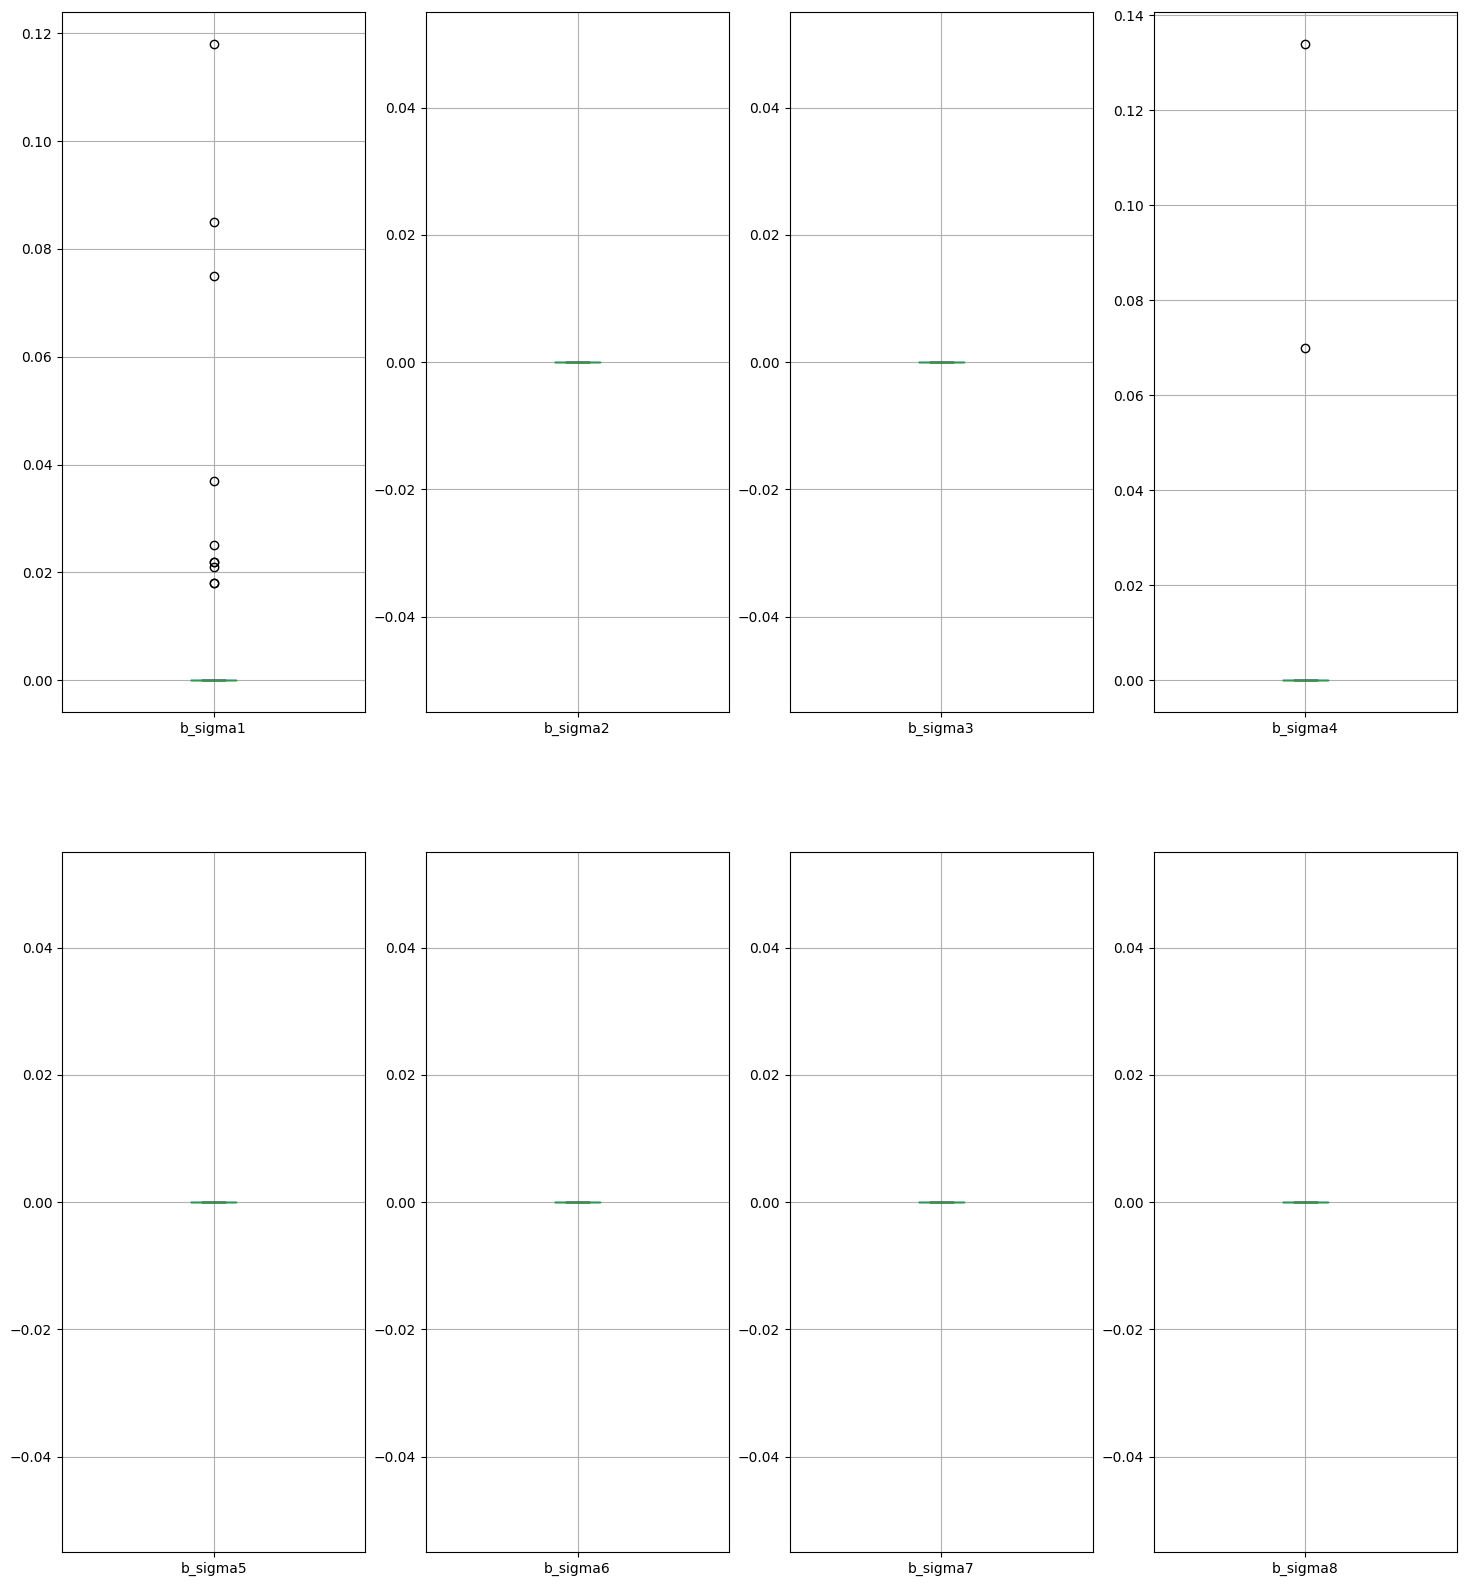

In [491]:
fig, axes = plt.subplots(2,4, figsize=(18,20))
for i in range(1,9):
    df_penal_sigma.boxplot(column=['b_sigma'+str(i)], ax=axes.flatten()[i-1])

### Print info about important penalization

In [495]:
def print_important_branch_penal_Zscore(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        data_index = df_penal['branch'].get(index) - 1
        gap = 100 * element / (df_data[elem_penal].get(data_index)+0.0000001)
        string = "Branch/transfo n°"
        
        if 'num' in df_data.keys():
            string += str(df_data['num'].get(data_index))

        bus1, bus2 = df_data['bus1'].get(data_index), df_data['bus2'].get(data_index)
        string += ", between bus " + str(bus1) + " and " + str(bus2)
        string += " with id \"" + df_data['id'].get(data_index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_branch_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():

        data_index = df_penal['branch'].get(index) - 1 # -1 FIXME ????
        gap = 100 * element / (df_data[elem_penal].get(data_index)+0.0000001)
        string = "Branch/transfo n°"
        
        if 'num' in df_data.keys():
            string += str(df_data['num'].get(data_index))

        bus1, bus2 = df_data['bus1'].get(data_index), df_data['bus2'].get(data_index)
        string += ", between bus " + str(bus1) + " and " + str(bus2)
        string += " with id \"" + df_data['id'].get(data_index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_bus_penal_IQR(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_IQR(df_penal[var_penal].abs(), threshold).items():
        gap = 100 * element / (df_data[elem_penal].get(index)+0.0000001)
        string = "Bus n°" + str(df_penal['busPV'].get(index))
        string += " with id \"" + df_data['id'].get(index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

def print_important_bus_penal_Zscore(var_penal, df_penal, df_data, threshold, elem_penal):
    """ Print some information on the penalization of df['elem_penal'] values. """

    print("# ABOUT {elem_penal} PENALIZATION".format(elem_penal=elem_penal.upper()))
    for index, element in return_up_outliers_Zscore(df_penal[var_penal].abs(), threshold).items():
        gap = 100 * element / (df_data[elem_penal].get(index)+0.0000001)
        string = "Bus n°" + str(df_penal['busPV'].get(index))
        string += " with id \"" + df_data['id'].get(index).strip("''")
        string += "\", important value of penalization : " + str(element) + "   (gap of " + "{:.2f}".format(gap) + "%)"
        print(string)
    print()

In [496]:
threshold = 0.1
print_important_bus_penal_IQR('s1', df_penal_s, df_penal_s, threshold, 'targetV')
print_important_branch_penal_IQR("sigma1", df_penal_sigma, df_branches, threshold, 'cst ratio (pu)')
print_important_branch_penal_IQR("sigma2", df_penal_sigma, df_penal_sigma, threshold, 'admittance')
print_important_branch_penal_IQR("sigma3", df_penal_sigma, df_penal_sigma, threshold, 'dephor')
print_important_branch_penal_IQR("sigma4", df_penal_sigma, df_penal_sigma, threshold, 'angper')
print_important_branch_penal_IQR("sigma5", df_penal_sigma, df_branches, threshold,'g1 (pu)')
print_important_branch_penal_IQR("sigma6", df_penal_sigma, df_branches, threshold,'b1 (pu)')
print_important_branch_penal_IQR("sigma7", df_penal_sigma, df_branches, threshold,'g2 (pu)')
print_important_branch_penal_IQR("sigma8", df_penal_sigma, df_branches, threshold,'b2 (pu)')


# ABOUT TARGETV PENALIZATION

# ABOUT CST RATIO (PU) PENALIZATION
Branch n°558, between bus 165 and 163 with id "323afa0e-0c95-4ace-a302-0ef8fe4d0a9a", important value of penalization : 0.181   (gap of 18.22%)
Branch n°559, between bus 165 and 163 with id "a80b8f6c-4315-49a6-9124-79406c3e2f26", important value of penalization : 0.223   (gap of 22.45%)
Branch n°565, between bus 173 and 177 with id "249f36da-85dd-46fa-90b8-af76bbbc1d74", important value of penalization : 0.003   (gap of 0.29%)
Branch n°567, between bus 175 and 176 with id "d5fd8d30-82c2-422a-8832-c5cfa1f32608", important value of penalization : 1.182   (gap of 114.05%)
Branch n°607, between bus 240 and 241 with id "05f43804-c1ea-416e-9f28-d867eaba6ed8", important value of penalization : 0.002   (gap of 0.19%)
Branch n°610, between bus 247 and 243 with id "8898f036-9c69-4787-84ff-61002cb2cfae", important value of penalization : 0.219   (gap of 24.21%)
Branch n°620, between bus 259 and 257 with id "80689dde-310b-4b3f-a9f6-

In [497]:
threshold = 4
print_important_bus_penal_Zscore('s1', df_penal_s, df_penal_s, threshold, 'targetV')
print_important_branch_penal_Zscore("sigma1", df_penal_sigma, df_branches, threshold, 'cst ratio (pu)')
print_important_branch_penal_Zscore("sigma2", df_penal_sigma, df_penal_sigma, threshold, 'admittance')
print_important_branch_penal_Zscore("sigma3", df_penal_sigma, df_penal_sigma, threshold, 'dephor')
print_important_branch_penal_Zscore("sigma4", df_penal_sigma, df_penal_sigma, threshold, 'angper')
print_important_branch_penal_Zscore("sigma5", df_penal_sigma, df_branches, threshold,'g1 (pu)')
print_important_branch_penal_Zscore("sigma6", df_penal_sigma, df_branches, threshold,'b1 (pu)')
print_important_branch_penal_Zscore("sigma7", df_penal_sigma, df_branches, threshold,'g2 (pu)')
print_important_branch_penal_Zscore("sigma8", df_penal_sigma, df_branches, threshold,'b2 (pu)')


# ABOUT TARGETV PENALIZATION

# ABOUT CST RATIO (PU) PENALIZATION
Branch n°567, between bus 175 and 176 with id "d5fd8d30-82c2-422a-8832-c5cfa1f32608", important value of penalization : 1.182   (gap of 114.05%)
Branch n°622, between bus 260 and 261 with id "53cff3d8-c066-4881-986d-c4ddb9e26ab6", important value of penalization : 0.858   (gap of 82.79%)
Branch n°687, between bus 370 and 371 with id "6b5db52c-1205-44a1-a48d-a2c01714352d", important value of penalization : 0.253   (gap of 24.25%)
Branch n°695, between bus 381 and 378 with id "4baa0f35-106e-435a-bea1-d7ed22be49e7", important value of penalization : 0.375   (gap of 41.45%)
Branch n°831, between bus 593 and 586 with id "e7ee862a-45d2-4176-9bbc-64d5270e8ea7", important value of penalization : 0.759   (gap of 83.89%)

# ABOUT ADMITTANCE PENALIZATION

# ABOUT DEPHOR PENALIZATION

# ABOUT ANGPER PENALIZATION
Branch n°, between bus 264 and 263 with id "875dd789-bc4a-46ab-996a-44ad90bd3eba", important value of penalization : 0.288